# Example offline pipeline

In [1]:
import filter
import IO
import projection
import offline_analysis
import rereference
import numpy as np
import json
import os
import pickle 
from matplotlib import pyplot as plt
import mne
mne.set_log_level(verbose='warning') #to avoid info at terminal

### 1. The first thing that you have to do is to build your settings file


In [2]:
settings = {}
settings['BIDS_path'] = "YOUR/ADDRESS"
settings['out_path'] = "YOUR/ADDRESS"
settings['resamplingrate']=10
settings['max_dist_cortex']=20
settings['max_dist_subcortex']=5
settings['normalization_time']=10
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]

In [3]:
#useful for Windows OS users
settings['BIDS_path']=settings['BIDS_path'].replace("\\", "/")
settings['out_path']=settings['out_path'].replace("\\", "/")

In [4]:
with open('settings/mysettings.json', 'w') as fp:
    json.dump(settings, fp)

In [5]:
settings = IO.read_settings('mysettings')

### 2. write _channels_M1 file


In [6]:
IO.write_all_M1_channel_files()

### 3. read_grid_points

In [7]:
cortex_left, cortex_right, subcortex_left, subcortex_right = IO.read_grid()
grid_ = [cortex_left, subcortex_left, cortex_right, subcortex_right]

### 4. read al vhdr_file.
YOU CAN EITHER READ THEM FOR A particular subject:
subject_path="address/where/subject/data/is/located"
subfolder=IO.get_subfolders(subject_path)
vhdr_files=IO.get_files(subject_path, subfolder)
OR read all vhdr files in a given BIDS PATH
vhdr_files=IO.get_all_vhdr_files(settings['BIDS_path'])

In [9]:
vhdr_files=IO.get_all_vhdr_files(settings['BIDS_path'])


### for every vhdr_files do the following:

In [10]:
vhdr_file=vhdr_files[0]

### 5. Get general information

In [11]:
#get info from vhdr_file
subject, run, sess = IO.get_sess_run_subject(vhdr_file)

In [12]:
#read sf
sf=IO.read_run_sampling_frequency(vhdr_file)
if len(sf.unique())==1: #all sf are equal
    sf=int(sf[0])
else: 
    Warning('Different sampling freq.')      


In [13]:
#read data
bv_raw, ch_names = IO.read_BIDS_file(vhdr_file)

In [14]:
#check session
sess_right = IO.sess_right(sess)
print(sess_right)

True


In [15]:
# read channels info
used_channels = IO.read_M1_channel_specs(vhdr_file[:-9])
print(used_channels)

{'cortex': array([0, 1, 2, 3, 4, 5]), 'subcortex': None, 'labels': array([6, 7], dtype=int64)}


### 6. extract data

In [19]:
# extract used channels/labels from brainvision file, split up in cortex/subcortex/labels
#dat_ is a dict
dat_ = IO.get_dat_cortex_subcortex(bv_raw, ch_names, used_channels)
ind_cortex=dat_['ind_cortex']
ind_subcortex=dat_['ind_subcortex']
dat_ECOG=dat_['dat_cortex']
dat_MOV=dat_['dat_label']
dat_STN=dat_['dat_subcortex']

### 7. Rereference data, is desired

In [21]:
dat_ECOG_r, dat_STN_r =rereference.rereference(run_string=vhdr_file[:-9], data_cortex=dat_ECOG, data_subcortex=dat_STN)

### 8. grid point projection calculation

In [22]:
# # #read all used coordinates from session coordinates.tsv BIDS file
coord_patient = IO.get_patient_coordinates(ch_names, ind_cortex, ind_subcortex, vhdr_file, settings['BIDS_path'])
# # # given those coordinates and the provided grid, estimate the projection matrix
proj_matrix_run = projection.calc_projection_matrix(coord_patient, grid_, sess_right, settings['max_dist_cortex'], settings['max_dist_subcortex'])
# #They show the relative weights of every channel for every gridpoint
# #if Empty, then that grid is not used
# # # this function tells you which points are actually active after the projection
arr_act_grid_points = IO.get_active_grid_points(sess_right, used_channels['labels'], ch_names, proj_matrix_run, grid_)

### 9. Feature extraction

In [27]:
seglengths = settings['seglengths']
        
# read line noise from participants.tsv
line_noise = IO.read_line_noise(settings['BIDS_path'],subject)
# get the lenght of the recording signals
recording_time = bv_raw.shape[1] 

#resample
normalization_samples = settings['normalization_time']*settings['resamplingrate']
new_num_data_points = int((bv_raw.shape[1]/sf)*settings['resamplingrate'])

# downsample_idx states the original brainvision sample indexes are used
downsample_idx = (np.arange(0,new_num_data_points,1)*sf/settings['resamplingrate']).astype(int)

# get filter coef
filter_fun = filter.calc_band_filters(settings['frequencyranges'], sample_rate=sf)

offset_start = int(seglengths[0] / (sf/settings['resamplingrate'])) 

rf_data_median, pf_data_median = offline_analysis.run(sf, settings['resamplingrate'], np.asarray(seglengths), settings['frequencyranges'], grid_, downsample_idx, bv_raw, line_noise, \
              sess_right, dat_, filter_fun, proj_matrix_run, arr_act_grid_points, new_num_data_points, ch_names, normalization_samples)

### 10. Label data

In [37]:
# # #psi or contralateral movement
label_channels = np.array(ch_names)[used_channels['labels']]
con_true = np.empty(len(label_channels), dtype=object)
y=np.empty((len(label_channels),new_num_data_points), dtype=object)

for m in range(len(label_channels)):
    #right session
    if sess_right is True:
        if 'RIGHT' in label_channels[m]:
            mov_ips=dat_MOV[m]
            con_true[m]=False
        else:
            mov_con=dat_MOV[m]
            con_true[m]=True

            #left session        
    else:
        if 'RIGHT' in label_channels[m]:
            mov_con=dat_MOV[m]
            con_true[m]=True

        else:
            mov_ips=dat_MOV[m]
            con_true[m]=False

   
                   
    target_channel_corrected, onoff, raw_target_channel=offline_analysis.baseline_correction(y=dat_MOV[m], Decimate=40,method='baseline_als', param=[1e2, 1e-4], thr=1e-1, normalize=True)
    events=offline_analysis.create_events_array(onoff=onoff, raw_target_channel=dat_MOV[m], sf=sf)

    y[m]=offline_analysis.generate_continous_label_array(L=new_num_data_points, sf=10, events=events)          

    

>>Signal decimation is being done
>>baseline_als is being used
>>Signal decimation is being done
>>baseline_als is being used


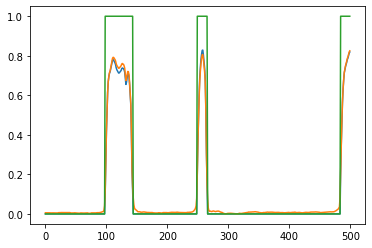

In [38]:
#plot baseline-correction
plt.plot(target_channel_corrected[0:500])
plt.plot(raw_target_channel[0:500])
plt.plot(onoff[0:500])

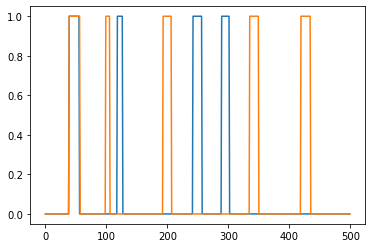

In [35]:
#plot continuos label vector
plt.plot(y[0][:500])
plt.plot(y[1][:500])


### 11. Save for run info